<a href="https://colab.research.google.com/github/vladimir3222003/Homework/blob/main/Project_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Классификация земной поверхности планеты по фотографиям со спутников**

<a name="overview"></a>
# Содержание
В данном проекте мы будем создавать модель, классифицирующую различные участки земной поверхности на 10 различных классов, разделяющиеся по собственным уникальным характеристикам




<a name="climate-impact"></a>
# Антропогенный рельеф и деятельность человека
В отчете Института мировых ресурсов (WRI) говорится, что около 23% глобальных антропогенных выбросов парниковых газов приходится на такие виды землепользования, как сельское хозяйство, лесоводство и расширение городов. Изменения в землепользовании, такие как обезлесение и деградация земель, являются одними из основных факторов, вызывающих эти выбросы. Стремительная урбанизация, ведущая к увеличению застроенных территорий, а также к массовому сокращению наземных запасов углерода, также может привести к значительным выбросам углерода.

Составление карт масштабов землепользования и категорий растительного покрова с течением времени имеет важное значение для улучшения экологического мониторинга, городского планирования и охраны природы. Например, мониторинг изменений в лесном покрове и выявление причин утраты лесов могут быть полезны для усилий по сохранению и восстановлению лесов. Оценка уязвимости определенных типов растительного покрова, таких как населенные пункты и сельскохозяйственные угодья, к определенным рискам также может быть полезна для планирования мероприятий по снижению риска бедствий, а также для долгосрочных усилий по адаптации к изменению климата.

Текущий реализуемый проект призван к решению описанных выше экологических проблем




В данном проекте реализованы следующие библиотеки:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

Начинаем наш проект с импорта необходимых библиотек

In [ ]:
# Стандартные библиотеки
import os
import random
from tqdm.notebook import tqdm

# Визуализация и манипуляция с данными
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Глубокое обучение
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms


SEED = 42
np.random.seed(SEED)

## Подключение к гугл коллаб



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Проверяем включен ли GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Получаем информацию о конкретной модели
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


## Используемые данные
В дальнейшей работе мы будем использовать данные со спутника Sentinel-2, которые в большом объеме представлены одним архивом EuroSAT.zip. Также в последующем для проверки на собственном датасете будем использовать любые похожие фотографии с того же спутника(https://commons.wikimedia.org/wiki/Category:Sentinel-2_images)

Но для начала, загружаем наш EuroSAT архив с нужного сайта

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2025-12-15 12:06:01--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  7.27MB/s    in 14s     

2025-12-15 12:06:16 (6.25 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]





### Создаем кастомный датасет
В Pytorch класс `Dataset` позволяет вам определить пользовательский класс для загрузки входных данных и целевого объекта для набора данных. Мы будем использовать эту возможность для загрузки наших входных данных в виде спутниковых изображений RGB вместе с соответствующими надписями. Позже мы узнаем, как применить необходимые преобразования изображения

In [ ]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Применяем преобразование
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Получаем интересующий наш класс картинки
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)




### Нормализация изображений по 3 каналам RGB
Ниже нами реализуется код torchvision.transforms.Normalize — функции в PyTorch, которая нормализует входные данные (в нашем случае - изображения) с помощью среднего и стандартного отклонения. Для нашей работы функция нормализует каждый из трех каналов до заданных средних значений и стандартных отклонений, определенных в переменных `imagenet_mean` и `imagenet_std`. ImageNet - это большой обучающий набор данных, состоящий из изображений и надписей. Далее в этом руководстве мы будем использовать модель, предварительно обученную на основе этого набора данных. Чтобы использовать эту предварительно обученную модель для нашего набора данных LULC, нам необходимо убедиться, что входной набор данных нормализован и имеет ту же статистику (среднее значение и стандартное отклонение), что и ImageNet.






In [ ]:
# Размер входного изображения для нейросети
# Большинство моделей (в т.ч. ResNet) ожидают изображения 224×224
input_size = 224

# Средние значения и стандартные отклонения для нормализации изображений
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]


# Трансформации для обучающей выборки
# Используются аугментации для повышения обобщающей способности модели
train_transform = transforms.Compose([
    # Случайное изменение масштаба и обрезка до нужного размера
    transforms.RandomResizedCrop(input_size),

    # Случайное отражение по горизонтали
    transforms.RandomHorizontalFlip(),

    # Случайное отражение по вертикали
    transforms.RandomVerticalFlip(),

    # Преобразование изображения из PIL в torch.Tensor
    # и перевод значений пикселей в диапазон [0, 1]
    transforms.ToTensor(),

    # Нормализация изображения по каналам (R, G, B)
    transforms.Normalize(imagenet_mean, imagenet_std)
])


# Трансформации для валидационной выборки
val_transform = transforms.Compose([
    # Изменение размера изображения
    transforms.Resize(input_size),

    # Центрированная обрезка до нужного размера
    transforms.CenterCrop(input_size),

    # Преобразование в Tensor
    transforms.ToTensor(),

    # Нормализация по статистикам ImageNet
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Трансформации для тестовой выборки
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Загрузка датасета с делением по классам
Начнем с загрузки набора данных EuroSAT с помощью класса ImageFolder от torch.

Изображения расположены в ImageFolder следующим образом:

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


**Как было сказано наши классы будут поделены на 10 различных типов в зависимости от различных особенностей каждого из учатска земной поверхности. Опишем их подробнее и выделим их особенности по фото со спутника**

**AnnualCrop** — однолетние сельхозкультуры(пшеница, кукуруза, ячмень, подсолнечник: чёткие прямоугольные поля, ровная текстура, часто полосатость от агротехники, цвет меняется по сезонам (зелёный → жёлтый → коричневый)

**Forest** — лес(плотные древесные массивы): тёмно-зелёный цвет, высокая текстурная плотность, отсутствие геометрической регулярности, «зернистая» структура

**HerbaceousVegetation** — травянистая растительность (не поля):природная
растительность без регулярной обработки(луга, степи, саванны) - более светлый зелёный, чем лес, однородная, но «мягкая» текстура, нет чётких границ полей

**Highway** — автомагистрали - крупные транспортные артерии: длинные узкие полосы, серо-чёрный цвет, часто пересечения и дуги,резкий контраст с окружающей территорией

**Industrial** — промышленные зоны(заводы, склады, ТЭЦ, нефтебазы и т.д): большие здания, крыши светло-серые / белые, хаотичное расположение, много асфальта и бетона

**Pasture** — пастбища, сельхозугодья для выпаса скота: зелёные поля, часто ограждённые, более «мягкая» структура, чем **AnnualCrop**, иногда видны тропинки животных, отличие от **HerbaceousVegetation** — антропогенное использование

**PermanentCrop** — многолетние культуры, растущие несколько лет подряд(виноградники, фруктовые сады и т.д): регулярные точечные или линейные паттерны,«сеточка», одинаковые расстояния между растениями

**Residential** — жилые районы: смесь крыш + дорог: мелкая структура, высокая фрагментация, хаотичнее, чем Industrial

**River** - реки: вытянутая форма, тёмно-синий / коричневатый цвет, извилистость, часто растительность по берегам

**SeaLake** — океаны, моря, озёра, водохранилища: большие однородные области,глубокий синий / тёмный цвет, минимальная текстура

In [ ]:
# Загружаем датасет
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Получаем категории(классы)
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Разделение выборо данных
Разделим набор данных на обучающий и тестовый наборы. Обучающий набор будет составлять 70% от набора данных Eurosat, выбранного случайным образом. Мы выделяем 15% набора данных в качестве проверочного набора, а оставшиеся 15% - в качестве тестового набора.

In [ ]:
# Применяем различные преобразования к обучающей и тестовой выборкам
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Разделяем наш датасет на 3 выборки(70% train / 15% val / 15% test)
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


Наконец, мы используем класс DataLoader torch для создания dataloader. dataloader управляет выборкой выборок из наборов данных (он может даже извлекать их параллельно, используя num_workers) и собирает пакеты наборов данных.

In [ ]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Визуализация

Визуализируем случайную часть набора данных из архива. Ячейка визуализирует входные данные для нейронной сети (изображение RGB) вместе с соответствующей меткой.


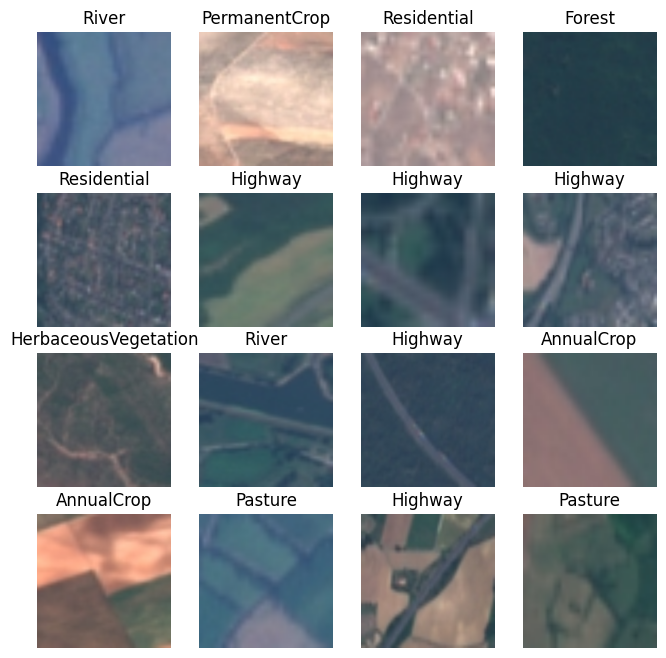

In [ ]:
n = 4 #Количество изображений по одной стороне сетки, gолучаем один батч из обучающего DataLoader
inputs, classes = next(iter(train_loader))
# Создаём сетку подграфиков для отображения изображений
fig, axes = plt.subplots(n, n, figsize=(8, 8))
# Проходим по строкам и столбцам сетки
for i in range(n):
  for j in range(n):
    # Извлекаем изображение из батча
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    # transpose нужен, так как PyTorch хранит изображения в формате [C, H, W], а matplotlib ожидает формат [H, W, C]
    # возвращаем значения пикселей к диапазону [0, 1]
    # Ограничиваем значения, чтобы избежать аномалий отображения
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

# Визуализация наших данных в виде гистограммы
Посмотрим сколько всего различных классов в нашем датасете в общем количестве


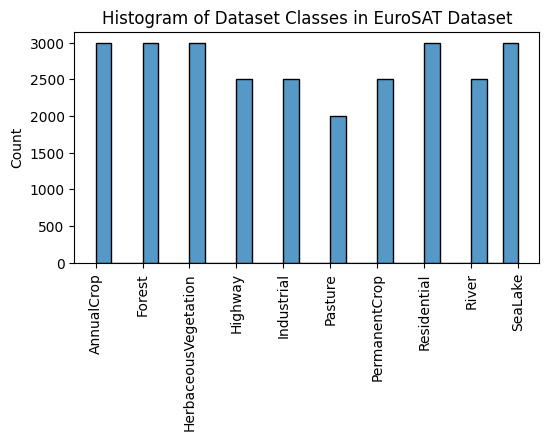

In [ ]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

## Инициализация модели

Начнем инициализировать нашу модель с использованием стандартной архитектуры нейронной сети, называемой ResNet50, которая хорошо подходит для классификации LULC по спутниковым изображениям на нашем датасете

### Почему именно ResNet-50?
 Причина использования конкретно этой архитектуры в том, что подобные нейронные сети, сложно обучать по подобным фото из-за проблемы исчезновения или увеличения градиентов (многократное умножение делает градиент бесконечно малым). ResNet решает эту проблему, используя короткие соединения, которые соединяют активацию с более раннего уровня на следующий уровень, пропуская один или несколько слоев, как показано ниже. Это позволяет градиентам распространяться на более глубокие слои, прежде чем они смогут быть уменьшены до малых или нулевых значений.

<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Image source: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>



In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

NameError: name 'device' is not defined

## Тренировка и оценка модели

Теперь мы можем приступить к обучению и оценке.

### Функция энтропии
В качестве критерия информативности будем применять функцию энтропии с лог потерями. Потери на перекрестную энтропию увеличиваются по мере того, как прогнозируемая вероятность отличается от фактической метки.

Для двух классов он вычисляется следующим образом:

$−ylog(p)-(1−y)log(1−p)$

Также для мультиклассов(в нашем случае):

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - количество классов
- $log$ - натуральный логарифм
- $y_{o,c}$ - двоичный индикатор (0 или 1), если метка класса $c$ является классификацией для наблюдения $o$
- $p_{o,c}$ - предсказанное вероятностное наблюдение $o$ относится к классу $c$

### Stochastic Gradient Descent
Remember that the goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.


In [ ]:
#Прописываем нужное нам количество эпох
n_epochs = 10
lr = 1e-3

# В качестве критерия прописываем функцию энтропии, прописываем оптимайзер
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Создаем функцию, которая будет обучать нашу модель

In [ ]:
def train(model, dataloader, criterion, optimizer):
  # Переводим модель в режим обучения
  model.train()
  # Переменные для накопления суммарной ошибки и количества верных предсказаний
  running_loss = 0.0
  running_total_correct = 0.0
  # Проходим по всем батчам обучающего датасета
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    # Переносим данные на выбранное устройство(GPU)
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Обнуляем градиенты параметров модели
    # Это необходимо, так как PyTorch накапливает градиенты
    optimizer.zero_grad()

    # Получаем выходы модели для текущего батча
    outputs = model(inputs)

    # Вычисляем значение функции потерь
    loss = criterion(outputs, labels)

    # Обратное распространение ошибки (backpropagation), вычисляем градиенты функции потерь по параметрам модели
    loss.backward()

    # Обновляем веса модели на основе вычисленных градиентов
    optimizer.step()

    # Считаем статистику
    _, preds = torch.max(outputs, 1)

    # Накапливаем суммарную ошибку, умножаем на размер батча для корректного подсчёта средней ошибки
    running_loss += loss.item() * inputs.size(0)
    # Накапливаем количество правильных предсказаний
    running_total_correct += torch.sum(preds == labels)

  # Среднее значение функции потерь за эпоху и точность эпохи
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

И функцию оценки нашей модели

In [ ]:
def evaluate(model, dataloader, criterion, phase="val"):
  # Переводим модель в режим оценки
  model.eval()
# Суммарные ошибки и верные предсказания
  running_loss = 0.0
  running_total_correct = 0.0
# Проходим по всем батчам датасета
  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    #Переносим данные на устройство
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Отключаем вычисление градиентов(Это ускоряет вычисления и снижает потребление памяти)
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  #Среднее значение функции потерь за эпоху и точность эпохи
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Собрав все это вместе, мы определяем функцию соответствия для обучения и оценки модели на обучающем наборе и проверочном наборе соответственно.


In [ ]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Отслеживаем лучшие веса с наименьшими потерями
  best_loss = np.inf
  # Переменная для хранения лучшей версии модели
  best_model = None

  # Основной цикл обучения по эпохам
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

Теперь мы можем приступить к обучению и оценке модели по нескольким эпохам(в нашем примере их 10)


In [ ]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.66; Accuracy: 51.85


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.08; Accuracy: 73.16
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.94; Accuracy: 72.00


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.60; Accuracy: 83.73
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.71; Accuracy: 77.26


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.42; Accuracy: 87.88
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.60; Accuracy: 80.71


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.33; Accuracy: 89.88
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.53; Accuracy: 83.11


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.29; Accuracy: 90.89
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.46; Accuracy: 84.77


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.24; Accuracy: 93.11
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.43; Accuracy: 86.02


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.19; Accuracy: 94.44
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.40; Accuracy: 86.79


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 94.86
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.38; Accuracy: 87.74


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 94.86
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.36; Accuracy: 88.10


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.15; Accuracy: 95.33


## Model Performance on the Test Set
Используя наилучшую модель, мы можем оценить производительность модели на тестовой выборке

In [ ]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.17; Accuracy: 94.52


## Сохранение модели

Сохраним нашу модель в гугл коллабе


In [ ]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [ ]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [ ]:
save_model(best_model, model_file)

NameError: name 'best_model' is not defined

## Загружаем нашу модель


In [ ]:
def load_model(model_file):


  model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  model.load_state_dict(torch.load(model_file))
  model.eval()

  print('Model file {} successfully loaded.'.format(model_file))
  return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.pth'
model = load_model(model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

<a name="results"></a>
# Результаты

Визуализируем пример работы нашей нейронной сети с указанным индексом(в нашем конкретном примере ниже - 297, можно поменять)

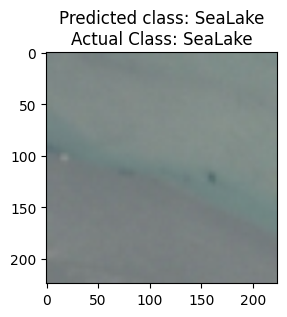

In [ ]:
# Выбор конкретного изображения из тестовой выборки
index = 297
# Получаем изображение и его истинную метку класса
image, label = test_data[index]

# Делаем предсказание
model = model.to("cpu")
output = model(image.unsqueeze(0))
# Получаем индекс класса с максимальной вероятностью
_, pred = torch.max(output, 1)

# Преобразование индексов в имена классов
label = class_names[label]
pred = class_names[pred[0]]

# Визуализация и предсказание
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

А тут мы запустим пример на наших конкретных изображениях с того же спутника. В нашем случае это фото жилого района(скорее всего скопления трейлеров) города Детройта

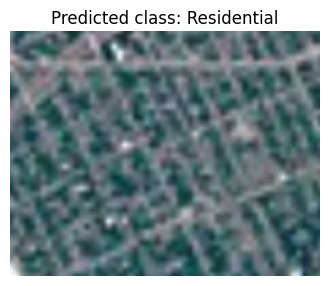

In [ ]:
# Путь к изображению
image_path = './drive/My Drive/Colab Notebooks/detroit.png'

# 1. Загрузка изображения + приведение к RGB
image = Image.open(image_path).convert("RGB")

# 2. Применение test_transform
input_tensor = test_transform(image)

# 3. Предсказание (без вычисления градиентов)
model.eval()
with torch.no_grad():
    output = model(input_tensor.unsqueeze(0))
    _, pred_idx = torch.max(output, dim=1)

# 4. Получение имени класса
pred_class = class_names[pred_idx.item()]

# 5. Визуализация
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f"Predicted class: {pred_class}")
plt.axis("off")
plt.show()
